In [1]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import yfinance as yf 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

plt.style.use('bmh')

In [3]:
ticker = 'INTC'
data = yf.download(ticker, period='10y', interval='1d', auto_adjust=True)
data 

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2012-03-02,20.052155,20.149062,19.955250,20.067064,29632800
2012-03-05,20.059612,20.059612,19.649624,19.783802,32332200
2012-03-06,19.567623,19.850887,19.530352,19.835979,37196700
2012-03-07,19.813619,20.126701,19.768894,20.059612,32720900
2012-03-08,20.126710,20.156528,19.940351,20.007441,37261600
...,...,...,...,...,...
2022-02-23,45.169998,45.709999,44.549999,44.650002,38176700
2022-02-24,43.900002,46.790001,43.630001,46.720001,72740100
2022-02-25,46.930000,47.790001,46.250000,47.709999,39266300


In [4]:
prices = data.Close.values
prices

array([20.06706429, 19.78380203, 19.83597946, ..., 47.70999908,
       47.70000076, 46.81999969])

In [5]:
X = []
y = []
n_lags = 12

for step in range(len(prices) - n_lags):
    X.append(prices[step:step+n_lags])
    y.append(prices[step+n_lags])
    
X = np.array(X)
y = np.array(y)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
y_tensor = torch.tensor(y, dtype=torch.float32, device=device)

cuda


In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_tensor, y_tensor, test_size=0.1, shuffle=False)

In [8]:
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)

batch_size = 128
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)

In [9]:
class CNN1dNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(192, 50)
        self.fc2 = nn.Linear(50, 1)
        self.dropout = nn.Dropout(0.4)
        
    def forward(self, x):
        x = F.relu(self.maxpool(self.conv(x)))
        x = torch.flatten(x, start_dim=1, end_dim=-1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [10]:
model = CNN1dNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
model

CNN1dNet(
  (conv): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=192, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [11]:
n_epochs = 1000
train_losses = np.empty(n_epochs, dtype=float)
valid_losses = np.empty(n_epochs, dtype=float)

for epoch in tqdm(range(n_epochs), ascii=True):
    running_train_loss = 0
    running_valid_loss = 0
    
    model.train()
    for X_batch, y_batch in train_dataloader:
        X_batch = X_batch.to(device).view(-1, 1, n_lags)
        y_batch = y_batch.to(device).view(-1, 1, 1)
        y_hat = model(X_batch).view(-1, 1, 1)
        loss = torch.sqrt(criterion(y_hat, y_batch))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * X_batch.size(0)
    train_losses[epoch] = running_train_loss / len(train_dataloader.dataset)
    
    with torch.no_grad():
        model.eval()
        for X_val, y_val in valid_dataloader:
            X_val = X_val.to(device).view(-1, 1, n_lags)
            y_val = y_val.to(device).view(-1, 1, 1)
            y_hat = model(X_val).view(-1, 1, 1)
            loss = torch.sqrt(criterion(y_hat, y_val))
            running_valid_loss += loss.item() * X_val.size(0)
        valid_losses[epoch] = running_valid_loss / len(valid_dataloader.dataset)
        
    if (epoch+1) % max(1, int(n_epochs*0.1)) == 0:
        tqdm.write(f"Epoch:{epoch+1}/{n_epochs} | TrainLoss:{train_losses[epoch]:.2f} | ValidLoss:{valid_losses[epoch]:.2f}")
        torch.save(model.state_dict(), f"CNN_{ticker}.pth")
        

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:100/1000 | TrainLoss:9.23 | ValidLoss:4.94
Epoch:200/1000 | TrainLoss:9.26 | ValidLoss:4.43
Epoch:300/1000 | TrainLoss:8.66 | ValidLoss:4.27
Epoch:400/1000 | TrainLoss:8.81 | ValidLoss:4.62
Epoch:500/1000 | TrainLoss:8.55 | ValidLoss:3.01
Epoch:600/1000 | TrainLoss:7.93 | ValidLoss:2.70
Epoch:700/1000 | TrainLoss:8.29 | ValidLoss:3.30
Epoch:800/1000 | TrainLoss:8.26 | ValidLoss:3.42
Epoch:900/1000 | TrainLoss:7.77 | ValidLoss:4.12
Epoch:1000/1000 | TrainLoss:7.18 | ValidLoss:2.36


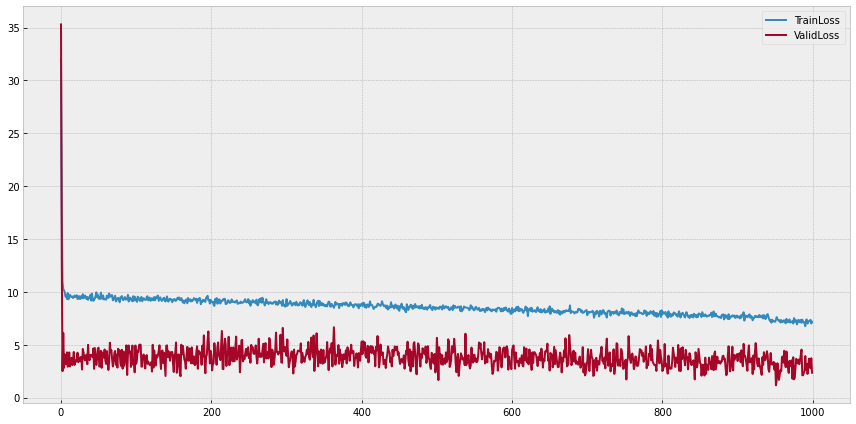

In [12]:
losses_df = pd.DataFrame(data={'TrainLoss':train_losses, 'ValidLoss':valid_losses})
losses_df.plot(figsize=(12,6))
plt.tight_layout()
plt.show()

In [13]:
trained_model = CNN1dNet().to(device)
trained_model.load_state_dict(torch.load(f"CNN_{ticker}.pth"))
trained_model.eval()

CNN1dNet(
  (conv): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=192, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [14]:
actuals = []
preds = []

with torch.no_grad():
    for X_batch, y_batch in valid_dataloader:
        X_batch = X_batch.to(device).view(-1, 1, n_lags)
        y_pred = trained_model(X_batch).cpu().numpy().flatten()
        actuals.append(y_batch.cpu().numpy())
        preds.append(y_pred)
        
actuals = np.concatenate(actuals)
preds = np.concatenate(preds)

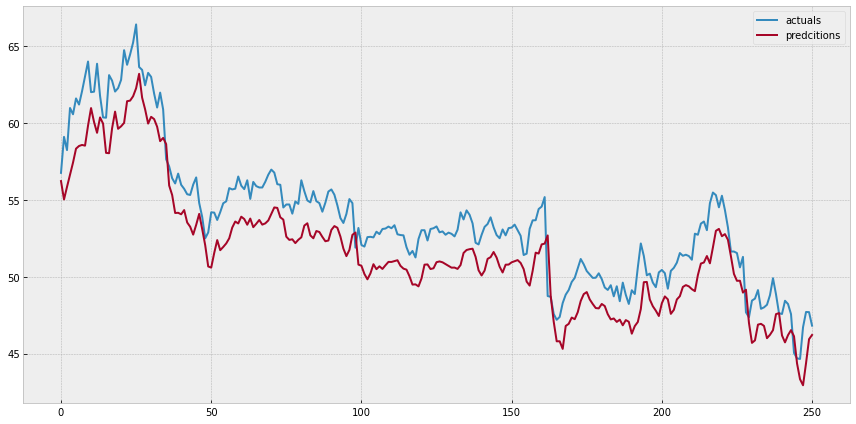

In [15]:
results_df = pd.DataFrame(data={'actuals':actuals, 'predcitions':preds})
results_df.plot(figsize=(12,6))
plt.tight_layout()
plt.show()

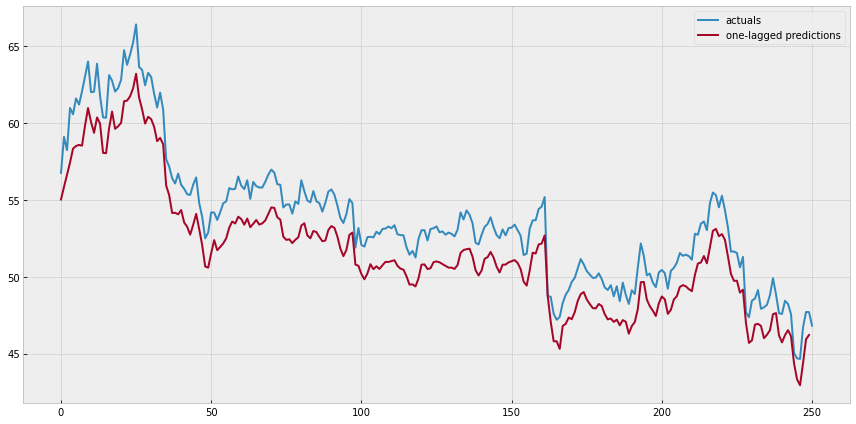

In [16]:
results_df['one-lagged predictions'] = results_df['predcitions'].shift(-1)
results_df[['actuals', 'one-lagged predictions']].plot(figsize=(12,6))
plt.tight_layout()
plt.show()